In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import pandas as pd
import torch.optim as optim

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [3]:
dataset_root_dir = "/datasets/COCO-2015"

In [4]:
from os import listdir
from os.path import isfile, join
listdir(dataset_root_dir)

['val2014', 'test2015', 'train2014']

In [5]:
class COCODataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224, 224),small_scale=True):
        super(COCODataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        if mode == "train":
            image_dir = join(root_dir, "train2014")     
        else:
            image_dir = join(root_dir,"val2014")
        index = 0
        data_dict = {}
        for file in listdir(image_dir):
            if file.endswith(".jpg"):
                data_dict[index]= join(image_dir,file)
                index += 1
        self.data = pd.Series(data_dict)
        if small_scale:
            self.data = self.data.iloc[:(len(self.data)//10)]
#         self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
#         self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")
    def __len__(self):
        return len(self.data)
    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]
        img = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([tv.transforms.Resize(self.image_size),
                                           tv.transforms.ToTensor(),
                                        ])
        x = transform(img)
        return x

In [6]:
train_COCO = COCODataset(dataset_root_dir,small_scale=False)
val_COCO = COCODataset(dataset_root_dir)

In [7]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
#     image = (image + 1) / 2
#     image[image < 0] = 0
#     image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [8]:
x = train_COCO.__getitem__(10)
len(train_COCO)

82783

<IPython.core.display.Javascript object>


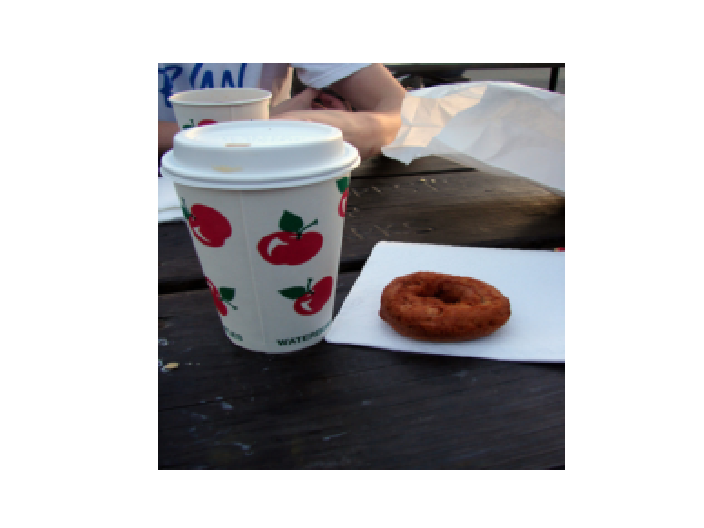

In [9]:
plt.figure(0)
myimshow(x)

In [11]:
style_root_dir = "./style"

In [12]:
class styleImage():
    def __init__(self, root_dir, image_name ,image_size=(224, 224)):
        self.image_size = image_size
        self.images_dir = join(root_dir, image_name)
    def __getitem__(self, idx):
        img = Image.open(self.images_dir)
        transform = tv.transforms.Compose([
            # COMPLETE
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor()])
        x = transform(img)
        return x

In [13]:
style_image = styleImage(style_root_dir,"the_starry_night.jpg")

<IPython.core.display.Javascript object>


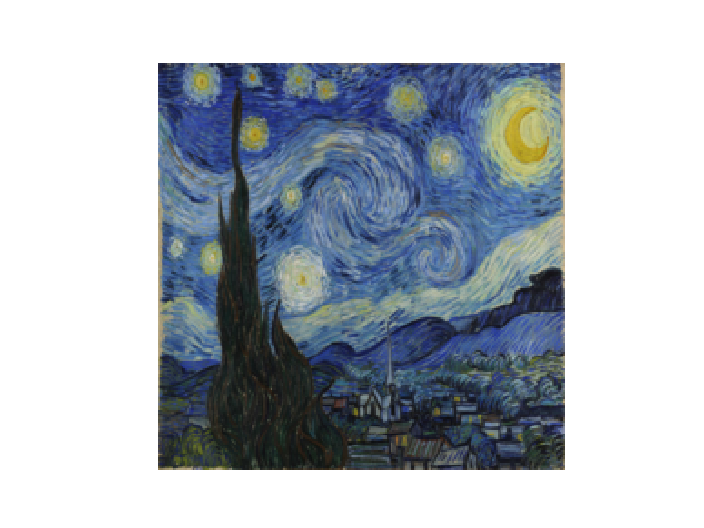

In [14]:
s_x = style_image.__getitem__(0)
plt.figure(1)
myimshow(s_x)

# Task 1 recap: Pre-trained VGG 

In [15]:
vgg = tv.models.vgg16(pretrained=True).features.to(device).eval()

In [16]:
class contentLoss(nn.Module):
    def __init__(self,target):
        super(contentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self,input):
#         print(input.shape, self.target.shape)
        self.loss = F.mse_loss(input, self.target)
        return input

In [17]:
def gram(input):
    batch_size, channel, height, width = input.shape
    x = input.view(batch_size*channel, height*width)
    return torch.mm(x, x.t())/(batch_size*channel*height*width)

In [18]:
class styleLoss(nn.Module):
    def __init__(self, target):
        super(styleLoss, self).__init__()
        self.target = target
        
        
    def forward(self, input):
        batch_size, channel, height, width = input.shape
        target_gram = gram(self.target)
        input_gram = gram(input)
        self.loss = F.mse_loss(input_gram, target_gram)*batch_size*channel*height*width
        return input

In [19]:
def constructModel(model, contentImg, styleImg, contentLayers, styleLayers):
    contentLoss_list = []
    styleLoss_list = []

    newModel = nn.Sequential()

    convCount = 0
    poolCount = 0
    reluCount = 0
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            convCount += 1
            name = 'conv_'+str(convCount)
            newModel.add_module(name, layer)
            if name in contentLayers:
                content = newModel(contentImg)
                content_loss = contentLoss(content)
                newModel.add_module("content_loss_"+str(convCount), content_loss)
                contentLoss_list.append(content_loss)

            if name in styleLayers:
                style = newModel(styleImg).detach()
                style_loss = styleLoss(style)
                newModel.add_module("style_loss_"+str(convCount), style_loss)
                styleLoss_list.append(style_loss)
        if isinstance(layer, nn.ReLU):
            reluCount += 1
            name = 'relu_'+str(reluCount)
            layer = nn.ReLU(inplace=False)
            newModel.add_module(name, layer)
        if isinstance(layer, nn.MaxPool2d):
            poolCount += 1
            name = 'pool_'+str(poolCount)
            newModel.add_module(name, nn.AvgPool2d((2,2)))

    return newModel, styleLoss_list, contentLoss_list

In [20]:
def trainHelper(contentImg, styleImg, epoch, model, contentLayers, styleLayers, beta):
    trainImg = contentImg
    input_param = trainImg.requires_grad_()
    optimizer = optim.LBFGS([input_param])
    newModel,styleLoss_list,contentLoss_list = constructModel(model, contentImg, styleImg, contentLayers, styleLayers )
    i = [0]
    while i[0] <= epoch:
        def closure():
            trainImg.data.clamp(0,1)
            optimizer.zero_grad()
            newModel(trainImg)
            content_loss = 0
            style_loss = 0
            for loss_val in contentLoss_list:
                content_loss += loss_val.loss
            for loss_val in styleLoss_list:
                style_loss += loss_val.loss
            totalLoss = content_loss * 1 + style_loss * beta
#             print(totalLoss)
            totalLoss.backward()
            i[0] += 1
            #if i[0] % 50 == 0:
                #print("epoch:" + str(i[0]))
                #print("Style Loss :" + str(style_loss))
                #print("Content Loss :" + str(content_loss))
            return totalLoss
        optimizer.step(closure)
    trainImg.data.clamp_(0,1)
    return trainImg,newModel

In [21]:
def core(newModel, trainImg, optimizer, contentLoss_list, styleLoss_list, i):
    trainImg.data.clamp(0,1)
    optimizer.zero_grad()
    newModel(trainImg)
    content_loss = 0
    style_loss = 0
    for loss_val in contentLoss_list:
        content_loss += loss_val.loss
    for loss_val in styleLoss_list:
        style_loss += loss_val.loss
    totalLoss = content_loss * 1 + style_loss * 100000
    totalLoss.backward()
    i[0] += 1
    #if i[0] % 50 == 0:
        #print("epoch:" + str(i[0]))
        #print("Style Loss :" + str(style_loss))
        #print("Content Loss :" + str(content_loss))
    return totalLoss

In [22]:
x = x.unsqueeze(0)
x = x.to(device,torch.float)
s_x = s_x.unsqueeze(0)
s_x = s_x.to(device,torch.float)

<IPython.core.display.Javascript object>


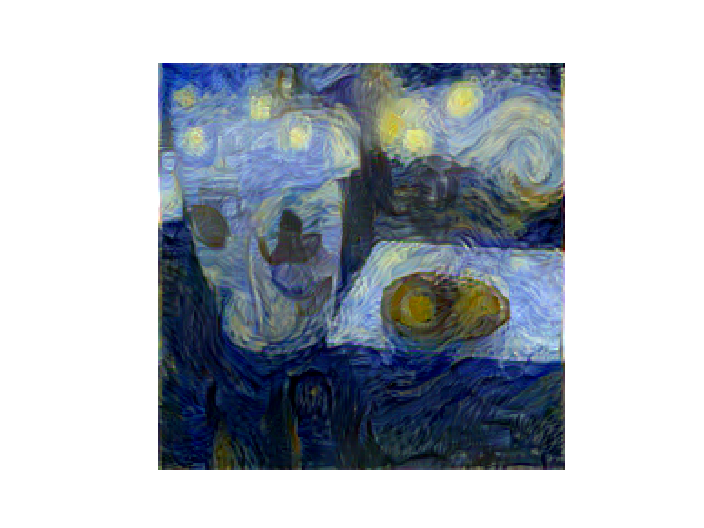

In [23]:
contentLayers = ['conv_7']
styleLayers = [['conv_2', 'conv_4', 'conv_7', 'conv_10']]
for i in range(len(styleLayers)):
    outputImg,newModel = trainHelper(x, s_x, 300, vgg, contentLayers, styleLayers[i], 10000)
    plt.figure(3)
    outputImg = outputImg.squeeze(0)
    myimshow(outputImg.detach(), ax=plt)

In [24]:
nn.Sequential(*list(newModel.children())[:-1])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): styleLoss()
  (4): ReLU()
  (5): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): styleLoss()
  (10): ReLU()
  (11): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): contentLoss()
  (18): styleLoss()
  (19): ReLU()
  (20): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (21): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (22): ReLU()
  

# Task 2: real time transfer, Train ResNet 

## 1.Residual Block 

In [60]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, 
                 out_channels, 
                 padding, 
                 norm_layer, 
                 dropout, 
                 bias,
                 non_lin):
        super(ResidualBlock,self).__init__()
###################################################################


#         in_channels:                    # of input channels
#         out_channels:                   # of output channels
#         padding:                         padding mode
#          norm_layer, :                "batchnorm" or "instancenorm"
#         droupout:                     boolean variable, if Ture use a droup out of 0.5
#         bias:                         boolean variable, if True, set bias of conved to true
#         non_lin                       non_linearity layer


######################################################################
        super(ResidualBlock, self).__init__()
        self.block = []
        conv1 = ConvLayer(in_channels, 
                          out_channels, 
                          kernel_size=3, 
                          stride=1,
                          padding=padding,bias=bias)
        self.block += [conv1]
        
        if norm_layer == "InstanceNorm":
            normal_layer = nn.InstanceNorm2d(in_channels)
        else:
            normal_layer = nn.BatchNorm2d(in_channels)
            
        self.block += [normal_layer,non_lin]
        if dropout:
            self.block += [nn.Dropout(0.5)]
        self.block += [conv1]
        self.block += [normal_layer]
        self.forward_func = nn.Sequential(*self.block)
    
    def forward(self, x):
        return x + self.forward_func(x)
    
    
class ConvLayer(nn.Module):
    def __init__(self, in_channels, 
                 out_channels,  
                 kernel_size,
                 stride,
                 padding,
                 bias):
        super(ConvLayer, self).__init__()
        self.block = []
        p = 0
        if padding == "reflect":
            self.block.append(nn.ReflectionPad2d(kernel_size//2))

        elif padding == "replicate":
            self.block.append(nn.ReplicationPad2d(kernel_size//2))

        else:
            p = 1
        self.block.append( nn.Conv2d(in_channels,
                                    out_channels, 
                                    kernel_size=kernel_size,
                                    stride=stride,
                                    padding=p, 
                                    bias=bias) )
        self.forward_func = nn.Sequential(*self.block)

    def forward(self,x):
        return self.forward_func(x)
    
    

## 2. Resnet constructor 

In [61]:
class ResNetGen(nn.Module):
    def __init__(self,
                 in_channels, 
                 out_channels, 
                 ngf,
                 padding, 
                 norm_layer, 
                 dropout, 
                 num_resblocks,
                 num_down_samp):
        super(ResNetGen,self).__init__()
#############################################################################################


#         in_channels:                    # of input channels
#         out_channels:                   # of output channels
#         ngf                             # of filters in the first conv layer
#         padding:                         padding mode
#         norm_layer:                      batch normal layer created outside of this class
#         droupout:                     boolean variable, if Ture use a droup out of 0.5
#         bias:                         boolean variable, if True, set bias of conved to true
#         num_resblocks                 number of residual blocks
#         num_down_samp                 number of down sampling
#                                       each contains a conv with stride 2


#############################################################################################
        bias = True
        net = [nn.ReflectionPad2d(4),
                 nn.Conv2d(in_channels,ngf, kernel_size=9,padding=0,bias=bias)
                ]
        if norm_layer == "InstanceNorm":
            net += [nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]
        else:
            net += [nn.BatchNorm2d(ngf),
                 nn.ReLU(True)]
        
        # downsampling
        for i in range(num_down_samp):
            mult = 2**i
            net += [nn.Conv2d(ngf*mult,ngf*mult*2, kernel_size=3, 
                              stride=2,padding=1, bias=bias)]
                   
            if norm_layer == "InstanceNorm":
                net += [nn.InstanceNorm2d(ngf*mult*2),
                     nn.ReLU(True)]
            else:
                net += [nn.BatchNorm2d(ngf*mult*2),
                     nn.ReLU(True)]  
                
        mult = mult * 2
        
        for i in range(num_resblocks):
            net += [ResidualBlock(in_channels=ngf*mult, 
                 out_channels=ngf*mult, 
                 padding=padding, 
                 norm_layer=norm_layer, 
                 dropout=dropout, 
                 bias=bias,
                 non_lin=nn.ReLU(True))]
            
        # upsampling   
        for i in range(num_down_samp):
            mult = 2**(num_down_samp-i)
            net += [nn.ConvTranspose2d(ngf*mult, 
                                       ngf*mult//2,
                                      kernel_size = 3,
                                      stride=2,
                                      padding=1,
                                      output_padding=1,
                                      bias = bias)]
                   
            if norm_layer == "InstanceNorm":
                net += [nn.InstanceNorm2d(ngf*mult//2),
                     nn.ReLU(True)]
            else:
                net += [nn.BatchNorm2d(ngf*mult//2),
                     nn.ReLU(True)]  

            
        net += [nn.ReflectionPad2d(4),
               nn.Conv2d(ngf,out_channels,kernel_size=9,padding=0),
               nn.Tanh()]
        self.net = nn.Sequential(*net)
        
    def forward(self,x):
        return self.net(x)

In [62]:
style_transfer = ResNetGen(3,3,64,"reflect","BatchNorm",False,5,2)

In [63]:
style_transfer

ResNetGen(
  (net): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): ResidualBlock(
      (forward_func): Sequential(
        (0): ConvLayer(
          (forward_func): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)


## 3.LossNetwork construction class

In [64]:
from collections import namedtuple

# reference : https://github.com/ceshine/fast-neural-style/blob/master/fast_neural_style/loss_network.py
# since the features are extract from relu instad of conv in task 1, the network has to be reconstructed
LossOutput = namedtuple("LossOutput", ["relu1", "relu2", "relu3", "relu4"])
class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork,self).__init__()
        self.vgg_layers = tv.models.vgg.vgg16(pretrained=True).features
        self.layer_name_mapping={
            '3':"relu1",
            '8':"relu2",
            '15':"relu3",
            '22':"relu4"
        }
        
    def forward(self,x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

##  4.gram matrix calculator

In [65]:
def gram_matrix(y):
    (b,ch,h,w) = y.shape
    features = y.view(b,ch,w*h)
    feature_t = features.transpose(1,2)
    gram = features.bmm(feature_t) / (ch*h*w)
    return gram

## 5.Funciton to Recover image from normalized image 

In [80]:
def recover_image(img):
    return (
        (
#             img *
#             np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) +
#             np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
            
            img *
            np.array([0.6, 0.6, 0.6]).reshape((1, 3, 1, 1)) +
            np.array([0.6, 0.6, 0.6]).reshape((1, 3, 1, 1))
        ).transpose(0, 2, 3, 1) *
        255.
    ).clip(0, 255).astype(np.uint8)

In [67]:
class styleImage():
    def __init__(self, root_dir, image_name ,image_size=(256, 256)):
        self.image_size = image_size
        self.images_dir = join(root_dir, image_name)
    def __getitem__(self, idx):
        img = Image.open(self.images_dir)
        transform = tv.transforms.Compose([
            # COMPLETE
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
#             tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225])]
             tv.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])]
        )
        x = transform(img).unsqueeze(0)
        return x

<IPython.core.display.Javascript object>


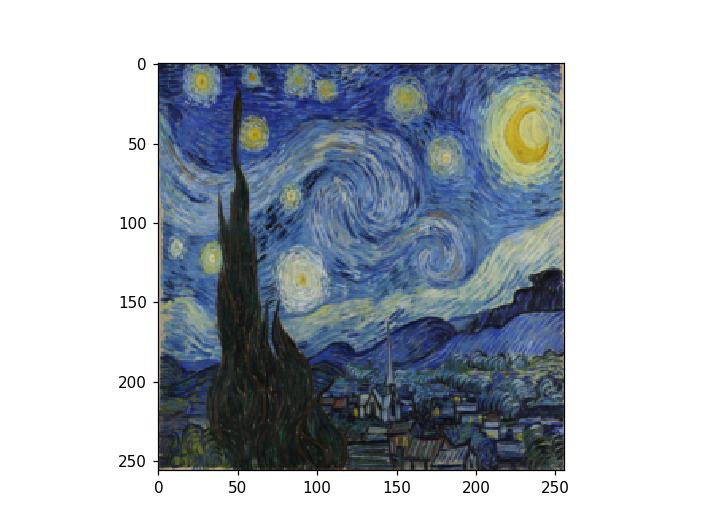

In [68]:
style_img = styleImage(style_root_dir,"the_starry_night.jpg")
style_img = style_img.__getitem__(0)
plt.figure(4)
plt.imshow(recover_image(style_img.cpu().numpy())[0])


In [16]:
with torch.no_grad():
    loss_network = LossNetwork()
    loss_network.to(device)
loss_network.eval()

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1

## 6. Calculate the gram of style image 

In [69]:
with torch.no_grad():
    style_img = style_img.to(device)
    style_loss_features = loss_network(style_img)
    gram_style = [gram_matrix(y) for y in style_loss_features]

## 7.Data loader to load normalized content train set 

In [70]:
class COCODataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(256, 256),small_scale=True):
        super(COCODataset, self).__init__()
        
#################################################################

#     root_dir:          root directory of the training set 
#     mode:              mode, train or validation(not used in this project) 
#     image_size:         length and withd of the output image 
#     small_scale=True:   if small scale is set to True, the loader only load 
#                         1/10 of the training data


#################################################################
        self.image_size = image_size
        self.mode = mode
        if mode == "train":
            image_dir = join(root_dir, "train2014")     
        else:
            image_dir = join(root_dir,"val2014")
        index = 0
        data_dict = {}
        for file in listdir(image_dir):
            if file.endswith(".jpg"):
                data_dict[index]= join(image_dir,file)
                index += 1
        self.data = pd.Series(data_dict)
        if small_scale:
            self.data = self.data.iloc[:(len(self.data)//10)]
    def __len__(self):
        return len(self.data)
    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]
        img = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([tv.transforms.Resize(self.image_size),
                                           tv.transforms.ToTensor(),
#                                            tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225])
                                           tv.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])
                                        ])
        x = transform(img)
        return x

In [71]:
train_COCO = COCODataset(dataset_root_dir,small_scale=True)
len(train_COCO)

8278

In [72]:
train_loader = td.DataLoader(train_COCO, batch_size=4, shuffle=True,drop_last=True)

In [73]:
def RT_transfer_train(loss_network, 
                      gen_resnet,
                      style_image,
                      train_loader,
                      num_epochs,
                      beta,
                      optimizer='adam'):
    gen_resnet = gen_resnet.to(device)
    loss_network = loss_network.to(device)
######################################################################

# input parameters:
#     loss_network:  container of loss_network, should be an instance of class drived from nn.Module  
#     gen_resnet:    container of the resnet
#     style_image:   style_image
#     train_loader:  train loader
#     num_epochs:    number of epoch
#     beta:          the style loss will multiplied by beta
#     optimizer:     default is adam optimizer   

# output :
# gen_resent:        containter of trained resnet 

######################################################################
    if optimizer == 'adam':
        optimizer = optim.Adam(gen_resnet.parameters())
   

    
#reference: https://github.com/ceshine/fast-neural-style/blob/master/notebooks/01-image-style-transfer.ipynb
    
    
    CONTENT_WEIGHT = 1
#     STYLE_WEIGHT = np.array([1e-1, 1, 1e1, 5, 1e1])*beta
    STYLE_WEIGHT = np.array([5e-1, 1, 1e1, 5])*beta
#     STYLE_WEIGHT = np.array([5e-1, 5, 1e1, 5, 1e1])*beta
#     STYLE_WEIGHT = np.array([1, 1, 1, 1])*beta
#     STYLE_WEIGHT = np.array([2e-1, 2e-1, 2e-1, 2e-1, 2e-1])*beta
    REGULARIZATION = 1e-6
    mse_loss = nn.MSELoss()
    for e in range(num_epochs):
        gen_resnet.train()
        
        image_count = 0
        
#         if e == 1:
#             STYLE_WEIGHT = STYLE_WEIGHT*5
            
        
        for x in train_loader:
            image_count += 4
            optimizer.zero_grad()
            x = x.to(device)
            y = gen_resnet(x)
            
            with torch.no_grad():
                xc = x.detach()
                
            features_y = loss_network(y)
            features_xc = loss_network(xc)
            
            with torch.no_grad():
                f_xc_c = features_xc[2].detach()
            
            
            content_loss = CONTENT_WEIGHT * mse_loss(features_y[2],f_xc_c)
            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))
            
            style_loss = 0
            for l, weight in enumerate(STYLE_WEIGHT):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                c, w, h = gram_y.shape
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y)) 
                
            total_loss = content_loss + style_loss + reg_loss
            print('total: ', total_loss.item(),
                  ' style: ', style_loss.item(),
                  ' content: ', content_loss.item(),
                  ' count: ', image_count, ' epoch: ',e)
            total_loss.backward()
            optimizer.step()

            
            


    return gen_resnet

In [74]:
device

'cuda'

In [75]:
style_transfer = ResNetGen(3,3,32,"reflect","BatchNorm",False,5,2)

In [76]:

gen_resnet = RT_transfer_train(loss_network,style_transfer,style_img,train_loader,2,3e5,'adam')



total:  116.39654541015625  style:  110.95919036865234  content:  5.152336120605469  count:  4  epoch:  0
total:  1610.3956298828125  style:  1599.3658447265625  content:  10.658533096313477  count:  8  epoch:  0
total:  339.33526611328125  style:  330.0403747558594  content:  8.951189041137695  count:  12  epoch:  0
total:  169.8953094482422  style:  162.82789611816406  content:  6.787548542022705  count:  16  epoch:  0
total:  246.82064819335938  style:  238.12893676757812  content:  8.39095687866211  count:  20  epoch:  0
total:  166.52194213867188  style:  159.49163818359375  content:  6.754387855529785  count:  24  epoch:  0
total:  194.8579559326172  style:  187.17982482910156  content:  7.401288032531738  count:  28  epoch:  0
total:  144.2777099609375  style:  136.759765625  content:  7.293542861938477  count:  32  epoch:  0
total:  126.21327209472656  style:  119.6975326538086  content:  6.313958168029785  count:  36  epoch:  0
total:  114.14969635009766  style:  106.869262695

total:  78.23745727539062  style:  71.6700668334961  content:  6.441102027893066  count:  320  epoch:  0
total:  78.17845153808594  style:  69.20062255859375  content:  8.831633567810059  count:  324  epoch:  0
total:  80.47306823730469  style:  73.55696105957031  content:  6.766880035400391  count:  328  epoch:  0
total:  76.34251403808594  style:  68.5796127319336  content:  7.610404968261719  count:  332  epoch:  0
total:  77.45350646972656  style:  68.6894760131836  content:  8.597905158996582  count:  336  epoch:  0
total:  78.31137084960938  style:  69.8235855102539  content:  8.286426544189453  count:  340  epoch:  0
total:  77.62895202636719  style:  68.58207702636719  content:  8.843297958374023  count:  344  epoch:  0
total:  76.27021789550781  style:  68.24983978271484  content:  7.86125373840332  count:  348  epoch:  0
total:  76.58777618408203  style:  71.15563201904297  content:  5.260972023010254  count:  352  epoch:  0
total:  78.82701110839844  style:  68.0258255004882

total:  58.922367095947266  style:  51.72224044799805  content:  7.000026702880859  count:  632  epoch:  0
total:  59.46950912475586  style:  51.82860565185547  content:  7.421296119689941  count:  636  epoch:  0
total:  64.20161437988281  style:  57.39059066772461  content:  6.620189666748047  count:  640  epoch:  0
total:  59.38109588623047  style:  50.204856872558594  content:  8.96822452545166  count:  644  epoch:  0
total:  61.33734130859375  style:  50.048072814941406  content:  11.099964141845703  count:  648  epoch:  0
total:  60.358882904052734  style:  51.95199966430664  content:  8.176774024963379  count:  652  epoch:  0
total:  63.33000183105469  style:  57.92191696166992  content:  5.173837184906006  count:  656  epoch:  0
total:  57.09199142456055  style:  48.96698760986328  content:  7.917489528656006  count:  660  epoch:  0
total:  54.04315948486328  style:  46.242919921875  content:  7.5821027755737305  count:  664  epoch:  0
total:  55.3825569152832  style:  46.822059

total:  40.92107009887695  style:  33.061805725097656  content:  7.576287269592285  count:  944  epoch:  0
total:  43.799530029296875  style:  34.347076416015625  content:  9.181363105773926  count:  948  epoch:  0
total:  41.999595642089844  style:  33.73788833618164  content:  7.964297294616699  count:  952  epoch:  0
total:  38.613651275634766  style:  29.232561111450195  content:  9.085850715637207  count:  956  epoch:  0
total:  37.42405700683594  style:  28.082813262939453  content:  9.066996574401855  count:  960  epoch:  0
total:  39.094810485839844  style:  31.58612632751465  content:  7.2201032638549805  count:  964  epoch:  0
total:  40.74778747558594  style:  30.06028175354004  content:  10.395678520202637  count:  968  epoch:  0
total:  43.73008346557617  style:  35.779972076416016  content:  7.661993026733398  count:  972  epoch:  0
total:  41.908016204833984  style:  33.31477737426758  content:  8.285046577453613  count:  976  epoch:  0
total:  37.98881149291992  style: 

total:  27.848112106323242  style:  19.029996871948242  content:  8.522107124328613  count:  1248  epoch:  0
total:  28.21489906311035  style:  18.215099334716797  content:  9.684633255004883  count:  1252  epoch:  0
total:  26.797042846679688  style:  16.903520584106445  content:  9.601908683776855  count:  1256  epoch:  0
total:  29.172964096069336  style:  20.244586944580078  content:  8.595636367797852  count:  1260  epoch:  0
total:  28.6583251953125  style:  20.422956466674805  content:  7.898027420043945  count:  1264  epoch:  0
total:  32.04348373413086  style:  20.871572494506836  content:  10.84784984588623  count:  1268  epoch:  0
total:  31.521408081054688  style:  20.017133712768555  content:  11.214613914489746  count:  1272  epoch:  0
total:  26.826522827148438  style:  17.4948673248291  content:  9.040582656860352  count:  1276  epoch:  0
total:  33.800506591796875  style:  23.39862823486328  content:  10.090251922607422  count:  1280  epoch:  0
total:  32.1273918151855

total:  25.9854736328125  style:  16.21127700805664  content:  9.468436241149902  count:  1552  epoch:  0
total:  24.611162185668945  style:  14.462618827819824  content:  9.854228973388672  count:  1556  epoch:  0
total:  29.14692497253418  style:  18.07904624938965  content:  10.761173248291016  count:  1560  epoch:  0
total:  24.094335556030273  style:  15.883721351623535  content:  7.907332420349121  count:  1564  epoch:  0
total:  24.7352352142334  style:  15.268075942993164  content:  9.160585403442383  count:  1568  epoch:  0
total:  25.09602165222168  style:  14.1006441116333  content:  10.692689895629883  count:  1572  epoch:  0
total:  23.851037979125977  style:  15.641779899597168  content:  7.903179168701172  count:  1576  epoch:  0
total:  24.276086807250977  style:  16.440902709960938  content:  7.522100448608398  count:  1580  epoch:  0
total:  27.491308212280273  style:  17.327125549316406  content:  9.840560913085938  count:  1584  epoch:  0
total:  28.467025756835938 

total:  23.283119201660156  style:  13.378440856933594  content:  9.59412670135498  count:  1856  epoch:  0
total:  23.182048797607422  style:  12.325536727905273  content:  10.558712005615234  count:  1860  epoch:  0
total:  26.496849060058594  style:  16.374608993530273  content:  9.82075023651123  count:  1864  epoch:  0
total:  24.230478286743164  style:  15.228950500488281  content:  8.689693450927734  count:  1868  epoch:  0
total:  23.57200813293457  style:  12.803727149963379  content:  10.468021392822266  count:  1872  epoch:  0
total:  26.50148582458496  style:  17.28043556213379  content:  8.904376983642578  count:  1876  epoch:  0
total:  24.219181060791016  style:  12.336174011230469  content:  11.58092975616455  count:  1880  epoch:  0
total:  22.201854705810547  style:  12.555970191955566  content:  9.356350898742676  count:  1884  epoch:  0
total:  21.083152770996094  style:  12.772034645080566  content:  8.019001960754395  count:  1888  epoch:  0
total:  24.82806777954

total:  21.31983184814453  style:  11.282371520996094  content:  9.752335548400879  count:  2160  epoch:  0
total:  20.223709106445312  style:  11.763687133789062  content:  8.165388107299805  count:  2164  epoch:  0
total:  20.64667510986328  style:  10.24286937713623  content:  10.113454818725586  count:  2168  epoch:  0
total:  21.1649169921875  style:  11.779205322265625  content:  9.121164321899414  count:  2172  epoch:  0
total:  21.932992935180664  style:  11.479219436645508  content:  10.164532661437988  count:  2176  epoch:  0
total:  22.330398559570312  style:  12.012969970703125  content:  10.028159141540527  count:  2180  epoch:  0
total:  28.161895751953125  style:  20.871566772460938  content:  7.021054267883301  count:  2184  epoch:  0
total:  23.09353256225586  style:  14.437707901000977  content:  8.39675521850586  count:  2188  epoch:  0
total:  21.33584976196289  style:  12.099843978881836  content:  8.96427059173584  count:  2192  epoch:  0
total:  20.05832481384277

total:  20.029956817626953  style:  11.448118209838867  content:  8.306732177734375  count:  2464  epoch:  0
total:  21.658411026000977  style:  10.428241729736328  content:  10.937572479248047  count:  2468  epoch:  0
total:  20.562610626220703  style:  10.023741722106934  content:  10.259767532348633  count:  2472  epoch:  0
total:  19.164541244506836  style:  9.617292404174805  content:  9.273399353027344  count:  2476  epoch:  0
total:  23.573511123657227  style:  12.509431838989258  content:  10.794775009155273  count:  2480  epoch:  0
total:  20.19601821899414  style:  11.049635887145996  content:  8.874058723449707  count:  2484  epoch:  0
total:  20.431846618652344  style:  10.463780403137207  content:  9.697064399719238  count:  2488  epoch:  0
total:  22.218650817871094  style:  11.987100601196289  content:  9.94626522064209  count:  2492  epoch:  0
total:  20.59598159790039  style:  11.705187797546387  content:  8.610382080078125  count:  2496  epoch:  0
total:  23.957536697

total:  19.907381057739258  style:  10.150412559509277  content:  9.485485076904297  count:  2768  epoch:  0
total:  18.170120239257812  style:  8.658697128295898  content:  9.24940013885498  count:  2772  epoch:  0
total:  19.142032623291016  style:  9.0178861618042  content:  9.857412338256836  count:  2776  epoch:  0
total:  19.481748580932617  style:  9.350284576416016  content:  9.87966251373291  count:  2780  epoch:  0
total:  17.698612213134766  style:  8.778356552124023  content:  8.65003776550293  count:  2784  epoch:  0
total:  20.731271743774414  style:  9.620930671691895  content:  10.840313911437988  count:  2788  epoch:  0
total:  18.301862716674805  style:  9.215655326843262  content:  8.81567668914795  count:  2792  epoch:  0
total:  17.86022186279297  style:  8.903812408447266  content:  8.680109024047852  count:  2796  epoch:  0
total:  19.868186950683594  style:  10.138246536254883  content:  9.453927040100098  count:  2800  epoch:  0
total:  19.563800811767578  styl

total:  20.187267303466797  style:  12.181488037109375  content:  7.730284690856934  count:  3072  epoch:  0
total:  19.18828010559082  style:  8.813037872314453  content:  10.1112699508667  count:  3076  epoch:  0
total:  19.240829467773438  style:  9.08312702178955  content:  9.907552719116211  count:  3080  epoch:  0
total:  18.376689910888672  style:  8.146143913269043  content:  9.971747398376465  count:  3084  epoch:  0
total:  17.9051513671875  style:  8.679777145385742  content:  8.96093463897705  count:  3088  epoch:  0
total:  17.4237117767334  style:  7.863702774047852  content:  9.3018217086792  count:  3092  epoch:  0
total:  18.2476749420166  style:  8.067774772644043  content:  9.925537109375  count:  3096  epoch:  0
total:  16.354923248291016  style:  8.626863479614258  content:  7.470945835113525  count:  3100  epoch:  0
total:  18.91519546508789  style:  8.265142440795898  content:  10.400254249572754  count:  3104  epoch:  0
total:  19.547359466552734  style:  8.6051

total:  17.60626983642578  style:  7.5594000816345215  content:  9.797911643981934  count:  3380  epoch:  0
total:  18.454082489013672  style:  6.687380313873291  content:  11.516191482543945  count:  3384  epoch:  0
total:  17.02810287475586  style:  7.199215888977051  content:  9.578725814819336  count:  3388  epoch:  0
total:  17.434545516967773  style:  9.418966293334961  content:  7.762572288513184  count:  3392  epoch:  0
total:  18.917709350585938  style:  8.146672248840332  content:  10.527088165283203  count:  3396  epoch:  0
total:  16.713014602661133  style:  7.144147872924805  content:  9.326738357543945  count:  3400  epoch:  0
total:  17.926799774169922  style:  7.744479179382324  content:  9.927140235900879  count:  3404  epoch:  0
total:  17.5067081451416  style:  7.754901885986328  content:  9.509090423583984  count:  3408  epoch:  0
total:  18.85997772216797  style:  9.40986156463623  content:  9.19671630859375  count:  3412  epoch:  0
total:  20.01779556274414  style

total:  17.8466854095459  style:  9.40145492553711  content:  8.195420265197754  count:  3684  epoch:  0
total:  17.617082595825195  style:  8.272390365600586  content:  9.097064018249512  count:  3688  epoch:  0
total:  16.7646427154541  style:  7.162092685699463  content:  9.350908279418945  count:  3692  epoch:  0
total:  17.248971939086914  style:  7.937305450439453  content:  9.072076797485352  count:  3696  epoch:  0
total:  18.074600219726562  style:  7.665705680847168  content:  10.159188270568848  count:  3700  epoch:  0
total:  16.245555877685547  style:  8.090356826782227  content:  7.8971686363220215  count:  3704  epoch:  0
total:  16.916370391845703  style:  7.413321018218994  content:  9.250715255737305  count:  3708  epoch:  0
total:  17.695819854736328  style:  7.562220573425293  content:  9.890077590942383  count:  3712  epoch:  0
total:  18.203214645385742  style:  8.196352005004883  content:  9.76323127746582  count:  3716  epoch:  0
total:  18.677982330322266  styl

total:  18.801603317260742  style:  6.522354602813721  content:  12.02900505065918  count:  3992  epoch:  0
total:  16.71499252319336  style:  6.042634010314941  content:  10.430581092834473  count:  3996  epoch:  0
total:  18.111045837402344  style:  7.032845973968506  content:  10.835673332214355  count:  4000  epoch:  0
total:  18.6051082611084  style:  6.968317031860352  content:  11.39360523223877  count:  4004  epoch:  0
total:  17.25596046447754  style:  6.9664740562438965  content:  10.050256729125977  count:  4008  epoch:  0
total:  17.555133819580078  style:  8.00767707824707  content:  9.321782112121582  count:  4012  epoch:  0
total:  16.776569366455078  style:  6.086150169372559  content:  10.450577735900879  count:  4016  epoch:  0
total:  17.8071346282959  style:  8.079075813293457  content:  9.49219799041748  count:  4020  epoch:  0
total:  16.56098747253418  style:  7.829733371734619  content:  8.485151290893555  count:  4024  epoch:  0
total:  17.44245147705078  style

total:  17.337970733642578  style:  7.151377201080322  content:  9.944900512695312  count:  4300  epoch:  0
total:  17.481258392333984  style:  6.727363586425781  content:  10.522430419921875  count:  4304  epoch:  0
total:  16.516590118408203  style:  7.122231960296631  content:  9.152817726135254  count:  4308  epoch:  0
total:  16.67707061767578  style:  6.617909908294678  content:  9.826189041137695  count:  4312  epoch:  0
total:  18.345035552978516  style:  6.113546371459961  content:  11.998238563537598  count:  4316  epoch:  0
total:  16.217687606811523  style:  6.245020866394043  content:  9.749643325805664  count:  4320  epoch:  0
total:  15.697883605957031  style:  6.3880181312561035  content:  9.093842506408691  count:  4324  epoch:  0
total:  15.724087715148926  style:  6.7470574378967285  content:  8.74359130859375  count:  4328  epoch:  0
total:  16.298614501953125  style:  6.167705535888672  content:  9.901087760925293  count:  4332  epoch:  0
total:  17.995018005371094

total:  17.26171112060547  style:  6.533436298370361  content:  10.502050399780273  count:  4608  epoch:  0
total:  16.159452438354492  style:  6.102770805358887  content:  9.829352378845215  count:  4612  epoch:  0
total:  17.222023010253906  style:  7.159631252288818  content:  9.848753929138184  count:  4616  epoch:  0
total:  16.45772361755371  style:  5.865346431732178  content:  10.371291160583496  count:  4620  epoch:  0
total:  16.26584815979004  style:  5.686010360717773  content:  10.35106372833252  count:  4624  epoch:  0
total:  16.41047477722168  style:  5.368642330169678  content:  10.818596839904785  count:  4628  epoch:  0
total:  16.618146896362305  style:  5.654895305633545  content:  10.731466293334961  count:  4632  epoch:  0
total:  15.293108940124512  style:  6.110641956329346  content:  8.963147163391113  count:  4636  epoch:  0
total:  16.8084659576416  style:  6.567150115966797  content:  10.007553100585938  count:  4640  epoch:  0
total:  15.154415130615234  s

total:  18.97600555419922  style:  7.176219940185547  content:  11.56769847869873  count:  4916  epoch:  0
total:  18.681577682495117  style:  8.237360000610352  content:  10.217427253723145  count:  4920  epoch:  0
total:  18.658477783203125  style:  7.656811714172363  content:  10.785968780517578  count:  4924  epoch:  0
total:  18.150182723999023  style:  7.620441436767578  content:  10.303464889526367  count:  4928  epoch:  0
total:  17.031387329101562  style:  7.0808563232421875  content:  9.7286958694458  count:  4932  epoch:  0
total:  16.389591217041016  style:  7.590738773345947  content:  8.57131290435791  count:  4936  epoch:  0
total:  19.848718643188477  style:  8.349142074584961  content:  11.261820793151855  count:  4940  epoch:  0
total:  18.245758056640625  style:  6.827952861785889  content:  11.187698364257812  count:  4944  epoch:  0
total:  18.18025779724121  style:  7.151731967926025  content:  10.798195838928223  count:  4948  epoch:  0
total:  17.615726470947266

total:  14.995223999023438  style:  6.004871368408203  content:  8.77389144897461  count:  5220  epoch:  0
total:  18.60773468017578  style:  7.395880699157715  content:  10.983264923095703  count:  5224  epoch:  0
total:  16.055484771728516  style:  6.766725540161133  content:  9.063970565795898  count:  5228  epoch:  0
total:  17.03875732421875  style:  6.127035617828369  content:  10.684118270874023  count:  5232  epoch:  0
total:  17.943710327148438  style:  8.638298034667969  content:  9.088150024414062  count:  5236  epoch:  0
total:  15.605147361755371  style:  6.566357612609863  content:  8.815021514892578  count:  5240  epoch:  0
total:  16.43951416015625  style:  6.3459577560424805  content:  9.864582061767578  count:  5244  epoch:  0
total:  14.914168357849121  style:  6.049102306365967  content:  8.63554573059082  count:  5248  epoch:  0
total:  17.12178611755371  style:  6.104403972625732  content:  10.790300369262695  count:  5252  epoch:  0
total:  15.306591987609863  st

total:  16.22954750061035  style:  5.427732467651367  content:  10.573063850402832  count:  5524  epoch:  0
total:  16.911863327026367  style:  5.388144493103027  content:  11.308317184448242  count:  5528  epoch:  0
total:  16.17323875427246  style:  5.721266746520996  content:  10.237793922424316  count:  5532  epoch:  0
total:  16.115930557250977  style:  6.932028770446777  content:  8.960978507995605  count:  5536  epoch:  0
total:  16.814476013183594  style:  5.155251502990723  content:  11.440790176391602  count:  5540  epoch:  0
total:  16.54915428161621  style:  5.793183326721191  content:  10.532873153686523  count:  5544  epoch:  0
total:  15.692846298217773  style:  5.025125026702881  content:  10.445297241210938  count:  5548  epoch:  0
total:  14.782690048217773  style:  5.7709431648254395  content:  8.785943031311035  count:  5552  epoch:  0
total:  15.933082580566406  style:  5.2981157302856445  content:  10.415003776550293  count:  5556  epoch:  0
total:  16.57378005981

total:  16.47418785095215  style:  5.164902687072754  content:  11.090015411376953  count:  5828  epoch:  0
total:  15.510427474975586  style:  5.706280708312988  content:  9.585119247436523  count:  5832  epoch:  0
total:  15.298233032226562  style:  5.0485968589782715  content:  10.02751636505127  count:  5836  epoch:  0
total:  13.808670043945312  style:  5.008835792541504  content:  8.58294677734375  count:  5840  epoch:  0
total:  16.495424270629883  style:  5.486550331115723  content:  10.786323547363281  count:  5844  epoch:  0
total:  17.50551414489746  style:  5.34409761428833  content:  11.944066047668457  count:  5848  epoch:  0
total:  14.329787254333496  style:  5.07053279876709  content:  9.046113014221191  count:  5852  epoch:  0
total:  16.105806350708008  style:  6.201000690460205  content:  9.688941955566406  count:  5856  epoch:  0
total:  15.268473625183105  style:  6.65451717376709  content:  8.39901065826416  count:  5860  epoch:  0
total:  14.92308521270752  styl

total:  14.384533882141113  style:  5.6248698234558105  content:  8.553107261657715  count:  6132  epoch:  0
total:  17.021535873413086  style:  5.4737749099731445  content:  11.344460487365723  count:  6136  epoch:  0
total:  17.06869125366211  style:  5.677900791168213  content:  11.1808443069458  count:  6140  epoch:  0
total:  16.71042251586914  style:  7.532891273498535  content:  8.971394538879395  count:  6144  epoch:  0
total:  16.786056518554688  style:  5.180960655212402  content:  11.388927459716797  count:  6148  epoch:  0
total:  15.986640930175781  style:  5.504751205444336  content:  10.26440143585205  count:  6152  epoch:  0
total:  17.98587989807129  style:  5.91480827331543  content:  11.85222053527832  count:  6156  epoch:  0
total:  16.98055076599121  style:  7.821266174316406  content:  8.947895050048828  count:  6160  epoch:  0
total:  14.655180931091309  style:  6.656820297241211  content:  7.773681640625  count:  6164  epoch:  0
total:  17.003582000732422  style

total:  13.412881851196289  style:  5.755176544189453  content:  7.440611839294434  count:  6440  epoch:  0
total:  14.077585220336914  style:  4.807143688201904  content:  9.056511878967285  count:  6444  epoch:  0
total:  16.05778694152832  style:  5.675213813781738  content:  10.175396919250488  count:  6448  epoch:  0
total:  15.077508926391602  style:  4.590577125549316  content:  10.273222923278809  count:  6452  epoch:  0
total:  13.618990898132324  style:  4.8903727531433105  content:  8.514331817626953  count:  6456  epoch:  0
total:  15.313570976257324  style:  5.175812721252441  content:  9.930764198303223  count:  6460  epoch:  0
total:  14.417411804199219  style:  5.246288299560547  content:  8.962756156921387  count:  6464  epoch:  0
total:  15.299595832824707  style:  5.200691223144531  content:  9.895846366882324  count:  6468  epoch:  0
total:  13.61207389831543  style:  4.779662609100342  content:  8.630144119262695  count:  6472  epoch:  0
total:  15.329964637756348 

total:  15.250842094421387  style:  5.821791648864746  content:  9.229989051818848  count:  6748  epoch:  0
total:  15.413411140441895  style:  4.997330188751221  content:  10.206911087036133  count:  6752  epoch:  0
total:  15.236710548400879  style:  5.326672554016113  content:  9.705914497375488  count:  6756  epoch:  0
total:  16.37681007385254  style:  5.26289176940918  content:  10.898550033569336  count:  6760  epoch:  0
total:  17.178789138793945  style:  4.879032135009766  content:  12.094016075134277  count:  6764  epoch:  0
total:  15.222847938537598  style:  5.166481971740723  content:  9.856375694274902  count:  6768  epoch:  0
total:  14.574089050292969  style:  5.317697525024414  content:  9.053275108337402  count:  6772  epoch:  0
total:  14.667573928833008  style:  5.247502326965332  content:  9.223512649536133  count:  6776  epoch:  0
total:  14.265340805053711  style:  5.294165134429932  content:  8.771209716796875  count:  6780  epoch:  0
total:  14.794025421142578 

total:  14.922325134277344  style:  4.6711835861206055  content:  10.048559188842773  count:  7056  epoch:  0
total:  14.96496295928955  style:  4.632602691650391  content:  10.129337310791016  count:  7060  epoch:  0
total:  16.122175216674805  style:  5.283775329589844  content:  10.639001846313477  count:  7064  epoch:  0
total:  14.501605033874512  style:  5.3116536140441895  content:  8.986703872680664  count:  7068  epoch:  0
total:  16.280187606811523  style:  4.727848052978516  content:  11.350885391235352  count:  7072  epoch:  0
total:  14.361871719360352  style:  4.898199081420898  content:  9.255858421325684  count:  7076  epoch:  0
total:  16.33495330810547  style:  4.750044822692871  content:  11.379249572753906  count:  7080  epoch:  0
total:  15.212552070617676  style:  4.883403301239014  content:  10.121851921081543  count:  7084  epoch:  0
total:  16.301271438598633  style:  4.098818778991699  content:  11.995872497558594  count:  7088  epoch:  0
total:  16.1714000701

total:  13.994865417480469  style:  4.684487342834473  content:  9.115177154541016  count:  7360  epoch:  0
total:  15.371859550476074  style:  3.9818458557128906  content:  11.186999320983887  count:  7364  epoch:  0
total:  15.210704803466797  style:  5.00910758972168  content:  9.994832992553711  count:  7368  epoch:  0
total:  15.658836364746094  style:  4.935421943664551  content:  10.528379440307617  count:  7372  epoch:  0
total:  14.227848052978516  style:  4.75609827041626  content:  9.275460243225098  count:  7376  epoch:  0
total:  15.107945442199707  style:  4.4834065437316895  content:  10.422553062438965  count:  7380  epoch:  0
total:  15.599837303161621  style:  4.210025310516357  content:  11.193490028381348  count:  7384  epoch:  0
total:  14.699235916137695  style:  4.916987895965576  content:  9.584280967712402  count:  7388  epoch:  0
total:  13.189948081970215  style:  4.297059535980225  content:  8.687335014343262  count:  7392  epoch:  0
total:  13.6011257171630

total:  14.648098945617676  style:  4.975343704223633  content:  9.476775169372559  count:  7664  epoch:  0
total:  15.41039752960205  style:  4.955471992492676  content:  10.260967254638672  count:  7668  epoch:  0
total:  15.041666984558105  style:  4.761617183685303  content:  10.076125144958496  count:  7672  epoch:  0
total:  13.489785194396973  style:  4.421450138092041  content:  8.873138427734375  count:  7676  epoch:  0
total:  15.767722129821777  style:  5.148619651794434  content:  10.41806411743164  count:  7680  epoch:  0
total:  15.014464378356934  style:  5.613157749176025  content:  9.206594467163086  count:  7684  epoch:  0
total:  15.334952354431152  style:  5.3463850021362305  content:  9.786214828491211  count:  7688  epoch:  0
total:  14.543643951416016  style:  4.459400177001953  content:  9.885141372680664  count:  7692  epoch:  0
total:  13.937653541564941  style:  4.716033935546875  content:  9.023862838745117  count:  7696  epoch:  0
total:  16.998531341552734

total:  15.100358009338379  style:  4.641962051391602  content:  10.259638786315918  count:  7972  epoch:  0
total:  14.694914817810059  style:  4.835452556610107  content:  9.659686088562012  count:  7976  epoch:  0
total:  13.780014991760254  style:  4.278745651245117  content:  9.303583145141602  count:  7980  epoch:  0
total:  14.502920150756836  style:  4.622490882873535  content:  9.673907279968262  count:  7984  epoch:  0
total:  15.620793342590332  style:  4.362911224365234  content:  11.059608459472656  count:  7988  epoch:  0
total:  13.313227653503418  style:  4.104578495025635  content:  9.013199806213379  count:  7992  epoch:  0
total:  16.03231430053711  style:  5.040387153625488  content:  10.79036808013916  count:  7996  epoch:  0
total:  14.656134605407715  style:  4.436625003814697  content:  10.027617454528809  count:  8000  epoch:  0
total:  16.55116844177246  style:  4.017063617706299  content:  12.335306167602539  count:  8004  epoch:  0
total:  15.435883522033691

total:  16.06446647644043  style:  4.422987937927246  content:  11.443087577819824  count:  8276  epoch:  0
total:  13.606050491333008  style:  4.408879280090332  content:  8.999015808105469  count:  4  epoch:  1
total:  15.9489164352417  style:  4.261858940124512  content:  11.483898162841797  count:  8  epoch:  1
total:  15.218213081359863  style:  4.602250576019287  content:  10.410280227661133  count:  12  epoch:  1
total:  14.518562316894531  style:  4.257339000701904  content:  10.06046199798584  count:  16  epoch:  1
total:  15.315156936645508  style:  4.531989097595215  content:  10.585676193237305  count:  20  epoch:  1
total:  15.432821273803711  style:  4.292949199676514  content:  10.938251495361328  count:  24  epoch:  1
total:  16.579442977905273  style:  4.705337047576904  content:  11.675176620483398  count:  28  epoch:  1
total:  14.660694122314453  style:  4.200667381286621  content:  10.26681900024414  count:  32  epoch:  1
total:  13.42819881439209  style:  4.443755

total:  14.212855339050293  style:  4.9932708740234375  content:  9.02054214477539  count:  312  epoch:  1
total:  14.179510116577148  style:  4.2983012199401855  content:  9.681962013244629  count:  316  epoch:  1
total:  14.2089204788208  style:  4.700063228607178  content:  9.311861038208008  count:  320  epoch:  1
total:  14.396247863769531  style:  3.9878451824188232  content:  10.214191436767578  count:  324  epoch:  1
total:  15.027572631835938  style:  4.074434280395508  content:  10.755674362182617  count:  328  epoch:  1
total:  14.23100471496582  style:  4.265380859375  content:  9.770818710327148  count:  332  epoch:  1
total:  13.299664497375488  style:  4.113203048706055  content:  8.992395401000977  count:  336  epoch:  1
total:  14.132576942443848  style:  4.318083763122559  content:  9.621235847473145  count:  340  epoch:  1
total:  14.415414810180664  style:  5.057193279266357  content:  9.159248352050781  count:  344  epoch:  1
total:  14.447601318359375  style:  4.0

total:  14.77235221862793  style:  4.060937404632568  content:  10.51622486114502  count:  624  epoch:  1
total:  13.637266159057617  style:  4.022579193115234  content:  9.419795989990234  count:  628  epoch:  1
total:  14.948284149169922  style:  4.453567981719971  content:  10.298136711120605  count:  632  epoch:  1
total:  14.875418663024902  style:  4.209826946258545  content:  10.47000503540039  count:  636  epoch:  1
total:  16.401613235473633  style:  7.205187797546387  content:  9.003046989440918  count:  640  epoch:  1
total:  16.203598022460938  style:  4.066711902618408  content:  11.939092636108398  count:  644  epoch:  1
total:  14.32785415649414  style:  4.1014509201049805  content:  10.036506652832031  count:  648  epoch:  1
total:  13.937621116638184  style:  4.294875621795654  content:  9.453255653381348  count:  652  epoch:  1
total:  14.188058853149414  style:  6.615017890930176  content:  7.384772300720215  count:  656  epoch:  1
total:  16.760112762451172  style: 

total:  16.557830810546875  style:  4.52692174911499  content:  11.838460922241211  count:  932  epoch:  1
total:  13.615567207336426  style:  4.335043907165527  content:  9.08961296081543  count:  936  epoch:  1
total:  13.841534614562988  style:  4.301708698272705  content:  9.350080490112305  count:  940  epoch:  1
total:  16.701271057128906  style:  4.660811424255371  content:  11.840815544128418  count:  944  epoch:  1
total:  14.587814331054688  style:  4.002288341522217  content:  10.392189025878906  count:  948  epoch:  1
total:  14.029338836669922  style:  4.087512969970703  content:  9.74494457244873  count:  952  epoch:  1
total:  13.44784164428711  style:  4.435910701751709  content:  8.816034317016602  count:  956  epoch:  1
total:  15.088716506958008  style:  5.101056098937988  content:  9.793102264404297  count:  960  epoch:  1
total:  14.623724937438965  style:  4.639169216156006  content:  9.788076400756836  count:  964  epoch:  1
total:  13.168425559997559  style:  4.

total:  15.40075969696045  style:  4.186692714691162  content:  11.015573501586914  count:  1240  epoch:  1
total:  14.307591438293457  style:  4.707474708557129  content:  9.403707504272461  count:  1244  epoch:  1
total:  16.441064834594727  style:  4.501428604125977  content:  11.744986534118652  count:  1248  epoch:  1
total:  13.91274356842041  style:  4.1148600578308105  content:  9.609253883361816  count:  1252  epoch:  1
total:  14.276643753051758  style:  4.613270282745361  content:  9.476638793945312  count:  1256  epoch:  1
total:  12.641737937927246  style:  4.153249263763428  content:  8.301619529724121  count:  1260  epoch:  1
total:  14.59616756439209  style:  4.331510543823242  content:  10.069515228271484  count:  1264  epoch:  1
total:  12.937712669372559  style:  4.057277202606201  content:  8.69035530090332  count:  1268  epoch:  1
total:  15.009047508239746  style:  4.415502548217773  content:  10.404635429382324  count:  1272  epoch:  1
total:  14.683586120605469 

total:  14.490190505981445  style:  4.56041145324707  content:  9.734607696533203  count:  1548  epoch:  1
total:  16.003890991210938  style:  4.581836700439453  content:  11.22705078125  count:  1552  epoch:  1
total:  16.100271224975586  style:  3.9898271560668945  content:  11.919776916503906  count:  1556  epoch:  1
total:  12.588505744934082  style:  4.0227274894714355  content:  8.370342254638672  count:  1560  epoch:  1
total:  12.746427536010742  style:  4.25926399230957  content:  8.294954299926758  count:  1564  epoch:  1
total:  13.342024803161621  style:  4.086841106414795  content:  9.067832946777344  count:  1568  epoch:  1
total:  14.405097961425781  style:  4.156280517578125  content:  10.065814971923828  count:  1572  epoch:  1
total:  14.650625228881836  style:  5.5722222328186035  content:  8.89066219329834  count:  1576  epoch:  1
total:  14.36113452911377  style:  4.426912307739258  content:  9.74667739868164  count:  1580  epoch:  1
total:  15.696813583374023  sty

total:  12.68408203125  style:  4.196309566497803  content:  8.292535781860352  count:  1852  epoch:  1
total:  12.536197662353516  style:  4.321280479431152  content:  8.0294189453125  count:  1856  epoch:  1
total:  14.952588081359863  style:  4.357675552368164  content:  10.399415969848633  count:  1860  epoch:  1
total:  14.733671188354492  style:  4.247920513153076  content:  10.291304588317871  count:  1864  epoch:  1
total:  14.294048309326172  style:  4.130982875823975  content:  9.969106674194336  count:  1868  epoch:  1
total:  14.861632347106934  style:  4.111316680908203  content:  10.564285278320312  count:  1872  epoch:  1
total:  13.92945671081543  style:  3.7167723178863525  content:  10.02542495727539  count:  1876  epoch:  1
total:  16.01871109008789  style:  4.979267597198486  content:  10.853334426879883  count:  1880  epoch:  1
total:  14.742227554321289  style:  3.7967143058776855  content:  10.753617286682129  count:  1884  epoch:  1
total:  12.736311912536621  s

total:  14.623669624328613  style:  3.9794209003448486  content:  10.45233154296875  count:  2160  epoch:  1
total:  14.489919662475586  style:  4.558291435241699  content:  9.741353988647461  count:  2164  epoch:  1
total:  14.797066688537598  style:  4.141454219818115  content:  10.467187881469727  count:  2168  epoch:  1
total:  14.27245044708252  style:  3.7573609352111816  content:  10.320877075195312  count:  2172  epoch:  1
total:  12.58702278137207  style:  3.900724411010742  content:  8.502080917358398  count:  2176  epoch:  1
total:  14.306069374084473  style:  4.153696060180664  content:  9.969168663024902  count:  2180  epoch:  1
total:  12.665260314941406  style:  3.8972573280334473  content:  8.577812194824219  count:  2184  epoch:  1
total:  14.961990356445312  style:  3.785416603088379  content:  10.990442276000977  count:  2188  epoch:  1
total:  16.023073196411133  style:  4.257901191711426  content:  11.576260566711426  count:  2192  epoch:  1
total:  14.034841537475

total:  14.521429061889648  style:  4.136699676513672  content:  10.20110034942627  count:  2468  epoch:  1
total:  14.63450813293457  style:  3.9077260494232178  content:  10.539117813110352  count:  2472  epoch:  1
total:  12.49185562133789  style:  3.439741611480713  content:  8.867940902709961  count:  2476  epoch:  1
total:  14.373642921447754  style:  3.867189884185791  content:  10.31838321685791  count:  2480  epoch:  1
total:  13.539698600769043  style:  3.8237550258636475  content:  9.531106948852539  count:  2484  epoch:  1
total:  15.677596092224121  style:  4.420348644256592  content:  11.06895637512207  count:  2488  epoch:  1
total:  13.436867713928223  style:  3.9462976455688477  content:  9.307930946350098  count:  2492  epoch:  1
total:  13.253063201904297  style:  4.000193119049072  content:  9.064208984375  count:  2496  epoch:  1
total:  14.086393356323242  style:  3.8645808696746826  content:  10.03798770904541  count:  2500  epoch:  1
total:  12.376218795776367  

total:  13.488810539245605  style:  4.164713382720947  content:  9.140571594238281  count:  2776  epoch:  1
total:  13.09842586517334  style:  3.495631694793701  content:  9.417131423950195  count:  2780  epoch:  1
total:  12.791853904724121  style:  4.867718696594238  content:  7.743454933166504  count:  2784  epoch:  1
total:  13.833420753479004  style:  4.612603187561035  content:  9.032870292663574  count:  2788  epoch:  1
total:  13.615083694458008  style:  3.691697120666504  content:  9.732547760009766  count:  2792  epoch:  1
total:  15.461000442504883  style:  4.761300563812256  content:  10.520270347595215  count:  2796  epoch:  1
total:  14.05427360534668  style:  3.8099365234375  content:  10.05007266998291  count:  2800  epoch:  1
total:  13.368520736694336  style:  4.13620662689209  content:  9.042078018188477  count:  2804  epoch:  1
total:  14.051158905029297  style:  3.6348397731781006  content:  10.228157043457031  count:  2808  epoch:  1
total:  12.788814544677734  st

total:  15.498239517211914  style:  5.674614429473877  content:  9.636345863342285  count:  3084  epoch:  1
total:  13.936485290527344  style:  4.728560447692871  content:  9.025153160095215  count:  3088  epoch:  1
total:  14.122584342956543  style:  3.5638959407806396  content:  10.373058319091797  count:  3092  epoch:  1
total:  13.826105117797852  style:  4.414031982421875  content:  9.222833633422852  count:  3096  epoch:  1
total:  13.476967811584473  style:  5.752702713012695  content:  7.537937164306641  count:  3100  epoch:  1
total:  15.0958251953125  style:  3.628873586654663  content:  11.27958869934082  count:  3104  epoch:  1
total:  14.766443252563477  style:  3.9995274543762207  content:  10.580471992492676  count:  3108  epoch:  1
total:  13.882426261901855  style:  4.0049028396606445  content:  9.686573028564453  count:  3112  epoch:  1
total:  13.298046112060547  style:  3.993091583251953  content:  9.115387916564941  count:  3116  epoch:  1
total:  15.07242393493652

total:  13.792157173156738  style:  3.8228585720062256  content:  9.783884048461914  count:  3388  epoch:  1
total:  14.20712661743164  style:  5.280956268310547  content:  8.740489959716797  count:  3392  epoch:  1
total:  13.481365203857422  style:  3.986269950866699  content:  9.309325218200684  count:  3396  epoch:  1
total:  13.91010570526123  style:  4.2467241287231445  content:  9.47831916809082  count:  3400  epoch:  1
total:  15.731643676757812  style:  3.6982955932617188  content:  11.85135555267334  count:  3404  epoch:  1
total:  13.62712574005127  style:  3.584470510482788  content:  9.85814094543457  count:  3408  epoch:  1
total:  15.77190113067627  style:  5.212159633636475  content:  10.38099479675293  count:  3412  epoch:  1
total:  13.959179878234863  style:  4.210738182067871  content:  9.562005043029785  count:  3416  epoch:  1
total:  13.545923233032227  style:  3.7752163410186768  content:  9.58777904510498  count:  3420  epoch:  1
total:  13.248893737792969  sty

total:  14.298693656921387  style:  4.08737325668335  content:  10.031168937683105  count:  3692  epoch:  1
total:  13.207451820373535  style:  4.0969133377075195  content:  8.928312301635742  count:  3696  epoch:  1
total:  15.294222831726074  style:  4.358977794647217  content:  10.749124526977539  count:  3700  epoch:  1
total:  14.117149353027344  style:  3.996142864227295  content:  9.941555976867676  count:  3704  epoch:  1
total:  13.86528205871582  style:  3.876980781555176  content:  9.804067611694336  count:  3708  epoch:  1
total:  13.91005802154541  style:  4.631397724151611  content:  9.092815399169922  count:  3712  epoch:  1
total:  14.544092178344727  style:  3.847792387008667  content:  10.514336585998535  count:  3716  epoch:  1
total:  12.52291488647461  style:  4.356884956359863  content:  7.98679780960083  count:  3720  epoch:  1
total:  12.653007507324219  style:  3.8531713485717773  content:  8.618680000305176  count:  3724  epoch:  1
total:  14.34389877319336  s

total:  13.746848106384277  style:  4.120643615722656  content:  9.447309494018555  count:  3996  epoch:  1
total:  14.135501861572266  style:  4.452913284301758  content:  9.504161834716797  count:  4000  epoch:  1
total:  15.331480979919434  style:  3.391798496246338  content:  11.756531715393066  count:  4004  epoch:  1
total:  13.051361083984375  style:  3.768057346343994  content:  9.103557586669922  count:  4008  epoch:  1
total:  14.976341247558594  style:  3.5210230350494385  content:  11.276138305664062  count:  4012  epoch:  1
total:  12.86512565612793  style:  3.8066532611846924  content:  8.88065242767334  count:  4016  epoch:  1
total:  13.299324035644531  style:  4.141125202178955  content:  8.979608535766602  count:  4020  epoch:  1
total:  13.488367080688477  style:  3.423201084136963  content:  9.883842468261719  count:  4024  epoch:  1
total:  15.12346363067627  style:  4.129127025604248  content:  10.812030792236328  count:  4028  epoch:  1
total:  13.015071868896484

total:  14.528250694274902  style:  3.653573989868164  content:  10.692939758300781  count:  4300  epoch:  1
total:  12.812542915344238  style:  4.895538806915283  content:  7.741037845611572  count:  4304  epoch:  1
total:  12.381804466247559  style:  4.089276313781738  content:  8.105925559997559  count:  4308  epoch:  1
total:  12.386033058166504  style:  3.755246639251709  content:  8.456433296203613  count:  4312  epoch:  1
total:  13.348462104797363  style:  3.9470362663269043  content:  9.227166175842285  count:  4316  epoch:  1
total:  12.97037410736084  style:  3.8468401432037354  content:  8.946063995361328  count:  4320  epoch:  1
total:  13.558382034301758  style:  3.740635395050049  content:  9.638799667358398  count:  4324  epoch:  1
total:  13.279438018798828  style:  3.406998872756958  content:  9.694841384887695  count:  4328  epoch:  1
total:  12.157010078430176  style:  3.7649199962615967  content:  8.212580680847168  count:  4332  epoch:  1
total:  12.06891918182373

total:  13.753350257873535  style:  3.865900754928589  content:  9.704605102539062  count:  4908  epoch:  1
total:  13.33547592163086  style:  3.8138489723205566  content:  9.34408187866211  count:  4912  epoch:  1
total:  13.026823997497559  style:  3.5071184635162354  content:  9.343488693237305  count:  4916  epoch:  1
total:  13.705228805541992  style:  3.7847516536712646  content:  9.741981506347656  count:  4920  epoch:  1
total:  13.062285423278809  style:  4.092566013336182  content:  8.791773796081543  count:  4924  epoch:  1
total:  13.883329391479492  style:  3.3017051219940186  content:  10.401899337768555  count:  4928  epoch:  1
total:  12.172269821166992  style:  3.621079444885254  content:  8.373876571655273  count:  4932  epoch:  1
total:  12.538396835327148  style:  3.9095489978790283  content:  8.449275970458984  count:  4936  epoch:  1
total:  12.510464668273926  style:  4.304525852203369  content:  8.029706954956055  count:  4940  epoch:  1
total:  14.4174613952636

total:  10.989840507507324  style:  3.3668744564056396  content:  7.446307182312012  count:  5216  epoch:  1
total:  13.142930030822754  style:  3.9102132320404053  content:  9.05561351776123  count:  5220  epoch:  1
total:  11.809349060058594  style:  3.717447280883789  content:  7.911293983459473  count:  5224  epoch:  1
total:  13.256285667419434  style:  4.309340476989746  content:  8.770759582519531  count:  5228  epoch:  1
total:  12.389613151550293  style:  3.8898348808288574  content:  8.323375701904297  count:  5232  epoch:  1
total:  14.335904121398926  style:  3.5526299476623535  content:  10.60605239868164  count:  5236  epoch:  1
total:  14.599200248718262  style:  4.834971904754639  content:  9.575477600097656  count:  5240  epoch:  1
total:  13.481300354003906  style:  4.125550746917725  content:  9.17843246459961  count:  5244  epoch:  1
total:  14.97520923614502  style:  3.490077495574951  content:  11.307388305664062  count:  5248  epoch:  1
total:  13.148419380187988

total:  13.909246444702148  style:  3.597604513168335  content:  10.137223243713379  count:  5524  epoch:  1
total:  12.728675842285156  style:  3.750286102294922  content:  8.80324935913086  count:  5528  epoch:  1
total:  12.400686264038086  style:  4.1339006423950195  content:  8.091508865356445  count:  5532  epoch:  1
total:  14.588409423828125  style:  3.6136674880981445  content:  10.797121047973633  count:  5536  epoch:  1
total:  13.949654579162598  style:  3.3936715126037598  content:  10.381797790527344  count:  5540  epoch:  1
total:  12.358373641967773  style:  3.6569509506225586  content:  8.527873992919922  count:  5544  epoch:  1
total:  13.676240921020508  style:  3.4549405574798584  content:  10.045404434204102  count:  5548  epoch:  1
total:  12.122251510620117  style:  3.1898105144500732  content:  8.75589370727539  count:  5552  epoch:  1
total:  12.612351417541504  style:  4.027629375457764  content:  8.409536361694336  count:  5556  epoch:  1
total:  13.751401901

total:  12.088899612426758  style:  3.9717957973480225  content:  7.941042423248291  count:  5828  epoch:  1
total:  13.554747581481934  style:  4.068115234375  content:  9.316765785217285  count:  5832  epoch:  1
total:  13.167986869812012  style:  3.799480676651001  content:  9.193127632141113  count:  5836  epoch:  1
total:  15.47887134552002  style:  4.004374027252197  content:  11.298773765563965  count:  5840  epoch:  1
total:  13.461298942565918  style:  4.482263088226318  content:  8.810301780700684  count:  5844  epoch:  1
total:  12.546131134033203  style:  3.9916837215423584  content:  8.3798246383667  count:  5848  epoch:  1
total:  13.78254508972168  style:  4.528015613555908  content:  9.082796096801758  count:  5852  epoch:  1
total:  12.280829429626465  style:  4.319526672363281  content:  7.7829155921936035  count:  5856  epoch:  1
total:  13.353178024291992  style:  3.8821980953216553  content:  9.288917541503906  count:  5860  epoch:  1
total:  13.334793090820312  st

total:  13.366117477416992  style:  3.73966646194458  content:  9.448874473571777  count:  6132  epoch:  1
total:  13.088726043701172  style:  3.632654905319214  content:  9.279627799987793  count:  6136  epoch:  1
total:  16.20442771911621  style:  4.255697727203369  content:  11.768320083618164  count:  6140  epoch:  1
total:  12.290112495422363  style:  3.516300678253174  content:  8.59961986541748  count:  6144  epoch:  1
total:  13.255966186523438  style:  5.309466361999512  content:  7.77379035949707  count:  6148  epoch:  1
total:  16.08254623413086  style:  5.915990352630615  content:  9.990297317504883  count:  6152  epoch:  1
total:  13.984075546264648  style:  3.667679786682129  content:  10.141908645629883  count:  6156  epoch:  1
total:  13.595335006713867  style:  3.8928537368774414  content:  9.529495239257812  count:  6160  epoch:  1
total:  13.249690055847168  style:  4.026666164398193  content:  9.050071716308594  count:  6164  epoch:  1
total:  14.5853853225708  styl

total:  14.717103004455566  style:  3.4323856830596924  content:  11.106056213378906  count:  6440  epoch:  1
total:  12.305007934570312  style:  3.302419424057007  content:  8.827384948730469  count:  6444  epoch:  1
total:  12.758977890014648  style:  3.5872182846069336  content:  8.992579460144043  count:  6448  epoch:  1
total:  14.1544189453125  style:  3.945634126663208  content:  10.034542083740234  count:  6452  epoch:  1
total:  13.241582870483398  style:  5.267917633056641  content:  7.798964500427246  count:  6456  epoch:  1
total:  13.58855152130127  style:  3.8667285442352295  content:  9.54175853729248  count:  6460  epoch:  1
total:  14.750514030456543  style:  4.489353179931641  content:  10.090508460998535  count:  6464  epoch:  1
total:  13.038843154907227  style:  3.4771323204040527  content:  9.389095306396484  count:  6468  epoch:  1
total:  16.092512130737305  style:  4.561357498168945  content:  11.355611801147461  count:  6472  epoch:  1
total:  12.6822147369384

total:  12.18539047241211  style:  3.951263666152954  content:  8.056868553161621  count:  6748  epoch:  1
total:  13.046195030212402  style:  4.680544376373291  content:  8.188196182250977  count:  6752  epoch:  1
total:  13.712782859802246  style:  3.5151309967041016  content:  10.020861625671387  count:  6756  epoch:  1
total:  12.747905731201172  style:  4.680925369262695  content:  7.896431922912598  count:  6760  epoch:  1
total:  11.399877548217773  style:  4.064455509185791  content:  7.163571834564209  count:  6764  epoch:  1
total:  13.084426879882812  style:  3.7672691345214844  content:  9.144594192504883  count:  6768  epoch:  1
total:  14.339914321899414  style:  3.770432710647583  content:  10.39264965057373  count:  6772  epoch:  1
total:  11.903388977050781  style:  3.913167715072632  content:  7.82108211517334  count:  6776  epoch:  1
total:  16.949058532714844  style:  4.045065402984619  content:  12.728639602661133  count:  6780  epoch:  1
total:  14.920949935913086

total:  12.626154899597168  style:  4.000288009643555  content:  8.450716018676758  count:  7056  epoch:  1
total:  13.461706161499023  style:  3.7977917194366455  content:  9.48750114440918  count:  7060  epoch:  1
total:  13.232823371887207  style:  4.146903038024902  content:  8.915395736694336  count:  7064  epoch:  1
total:  12.090228080749512  style:  4.5381646156311035  content:  7.385343074798584  count:  7068  epoch:  1
total:  13.443642616271973  style:  3.864826202392578  content:  9.402127265930176  count:  7072  epoch:  1
total:  14.21987247467041  style:  3.8222708702087402  content:  10.223560333251953  count:  7076  epoch:  1
total:  13.30180549621582  style:  3.717634916305542  content:  9.408055305480957  count:  7080  epoch:  1
total:  13.565065383911133  style:  4.097875595092773  content:  9.294772148132324  count:  7084  epoch:  1
total:  12.395891189575195  style:  3.8136093616485596  content:  8.411767959594727  count:  7088  epoch:  1
total:  13.036844253540039

total:  12.949920654296875  style:  3.4994454383850098  content:  9.279218673706055  count:  7360  epoch:  1
total:  13.551666259765625  style:  3.523545742034912  content:  9.856534004211426  count:  7364  epoch:  1
total:  14.079824447631836  style:  3.6034493446350098  content:  10.30746841430664  count:  7368  epoch:  1
total:  14.606620788574219  style:  4.023730754852295  content:  10.414042472839355  count:  7372  epoch:  1
total:  13.333547592163086  style:  3.7865700721740723  content:  9.37399959564209  count:  7376  epoch:  1
total:  13.298532485961914  style:  3.5077097415924072  content:  9.623198509216309  count:  7380  epoch:  1
total:  13.391985893249512  style:  3.7571861743927  content:  9.460430145263672  count:  7384  epoch:  1
total:  13.067798614501953  style:  3.6434519290924072  content:  9.24990463256836  count:  7388  epoch:  1
total:  13.095962524414062  style:  3.5227298736572266  content:  9.40163803100586  count:  7392  epoch:  1
total:  13.270416259765625

total:  12.022012710571289  style:  4.004415988922119  content:  7.847128868103027  count:  7664  epoch:  1
total:  13.384795188903809  style:  4.0994391441345215  content:  9.110881805419922  count:  7668  epoch:  1
total:  13.997984886169434  style:  3.8690052032470703  content:  9.952832221984863  count:  7672  epoch:  1
total:  12.818846702575684  style:  3.8940112590789795  content:  8.75330638885498  count:  7676  epoch:  1
total:  13.017845153808594  style:  3.65998911857605  content:  9.187272071838379  count:  7680  epoch:  1
total:  13.93887996673584  style:  4.110229969024658  content:  9.656167030334473  count:  7684  epoch:  1
total:  11.391427993774414  style:  3.6693108081817627  content:  7.549595355987549  count:  7688  epoch:  1
total:  13.790862083435059  style:  3.3935739994049072  content:  10.22803783416748  count:  7692  epoch:  1
total:  12.814773559570312  style:  3.5906214714050293  content:  9.052664756774902  count:  7696  epoch:  1
total:  12.67332077026367

total:  12.268678665161133  style:  3.7132246494293213  content:  8.382942199707031  count:  7972  epoch:  1
total:  14.018671035766602  style:  4.3680620193481445  content:  9.479326248168945  count:  7976  epoch:  1
total:  12.962801933288574  style:  3.8982908725738525  content:  8.892366409301758  count:  7980  epoch:  1
total:  12.21633243560791  style:  4.027580261230469  content:  8.020533561706543  count:  7984  epoch:  1
total:  12.53048038482666  style:  3.814068078994751  content:  8.549484252929688  count:  7988  epoch:  1
total:  13.244026184082031  style:  4.194194793701172  content:  8.88127613067627  count:  7992  epoch:  1
total:  14.088369369506836  style:  3.7064249515533447  content:  10.207574844360352  count:  7996  epoch:  1
total:  13.457342147827148  style:  3.9537055492401123  content:  9.336002349853516  count:  8000  epoch:  1
total:  14.268791198730469  style:  3.6573047637939453  content:  10.440082550048828  count:  8004  epoch:  1
total:  11.822834968566

total:  12.445427894592285  style:  3.6463708877563477  content:  8.627684593200684  count:  8276  epoch:  1


In [77]:
x = train_COCO.__getitem__(11)
y = train_COCO.__getitem__(10)
z = train_COCO.__getitem__(30)
print(x.shape)


torch.Size([3, 256, 256])


In [78]:
x = x.unsqueeze(0)
x = x.to(device)
y = y.unsqueeze(0)
y = y.to(device)
z = z.unsqueeze(0)
z = z.to(device)
gen_resnet.eval()
out_img_x = gen_resnet(x)
out_img_y = gen_resnet(y)
out_img_z = gen_resnet(z)
# style_transfer.eval()
# out_img = style_transfer(x)

<IPython.core.display.Javascript object>


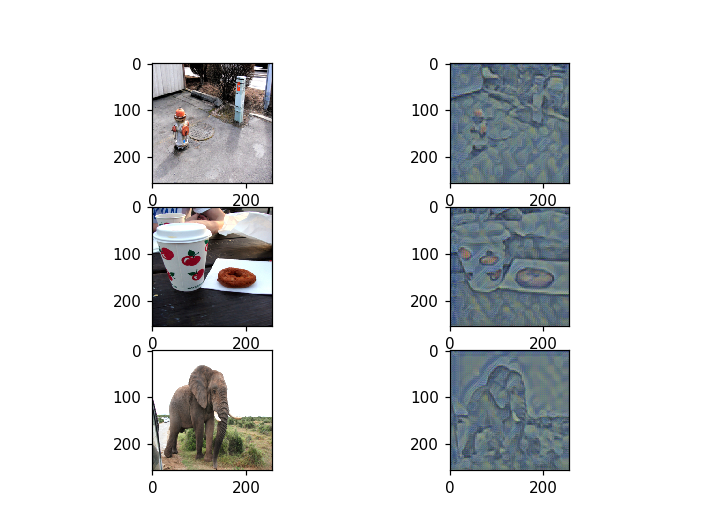

In [81]:
plt.figure(7)
plt.subplot(3,2,1)
plt.imshow(recover_image(x.detach().cpu().numpy())[0])

plt.subplot(3,2,2)
plt.imshow(recover_image(out_img_x.detach().cpu().numpy())[0])

plt.subplot(3,2,3)
plt.imshow(recover_image(y.detach().cpu().numpy())[0])

plt.subplot(3,2,4)
plt.imshow(recover_image(out_img_y.detach().cpu().numpy())[0])

plt.subplot(3,2,5)
plt.imshow(recover_image(z.detach().cpu().numpy())[0])

plt.subplot(3,2,6)
plt.imshow(recover_image(out_img_z.detach().cpu().numpy())[0])

